In [25]:
import pandas as pd
from plotnine import *
from PIL import Image, ImageDraw
import io

# theme for figures (plotnine)
theme_set(theme_bw())
theme_update(    
    axis_text = element_text(face="bold", size=15, angle=45, margin={"t" : 0, "r" : 0, "b" : 0, "l" : 0}),
    axis_text_x  = element_text(face = "bold", size = 15, angle = 45, margin = {"t" : 0, "r" : 0, "b" : 0, "l" : 0}),
    axis_text_y  = element_text(face = "bold", size = 15, angle = 45),
    
    plot_title   = element_text(alpha = 0.8, size = 15, face = "bold.italic"),
    axis_title_x = element_text(alpha = 0.8, size = 15, face = "bold", margin = {"t" : -2.5, "r" : 0, "b" : 0, "l" : 0}),
    axis_title_y = element_text(alpha = 0.8, size = 15, face = "bold", margin = {"t" : 0, "r" : 0, "b" : 0, "l" : 0}),
    
    strip_text_x = element_text(size = 15),
    strip_text_y = element_text(size = 15),
    legend_title = element_text(size = 17), 
    legend_text  = element_text(size = 17)
)

def fig_to_img(plotnine_fig):
    """
    Function for converting a plotnine figure to an PIL.Image image.
    """
    buf = io.BytesIO()
    im = plotnine_fig.save(buf, format='png', verbose=False)
    buf.seek(0)
    im = Image.open(buf)
    im.load()
    buf.close()
    return im

In [41]:
"""
Read in the data
(data comes from https://www.smhi.se/data/meteorologi/temperatur/uppsalas-temperaturserie-1.2855)
"""

df_temperature = pd.read_csv('uppsala_tm_1722-2019.dat', sep=' +',engine='python',
                                 index_col=False, header=None,
                                 names=["year", "month", "day", "obs", "obs_corr","loc"])

In [42]:
"""
Modify the data frame and do some simple calculations
"""

""" Make months should be categorical (for later plotting) """
df_temperature['month'] = df_temperature['month'].astype('category')

""" Use only the mean temperature for each month """
df = df_temperature.groupby(['year', 'month'], as_index=False)[['obs','obs_corr']].mean()

""" Calculate the record mean """
min_temp = df['obs_corr'].min()
max_temp = df['obs_corr'].max()

""" For each year, add current monthly min and max up to that year """
# start by setting the monthly temp as its min/max
df['c_max'] = df['obs_corr']
df['c_min'] = df['obs_corr']

# then go through each year and take either the current temp or the previous min/max as the new min/max
prev_year = df['year'].min()
for y in range(df['year'].min(),df['year'].max()+1):
    # get the indices of the rows for year y
    i_y = df.loc[df['year']==y].index
    
    # pick out the two last years
    df_2y = df.loc[df['year'].isin([y, prev_year])]
 
    # take the min/max of the two last years min/max as the new min/max
    df.loc[i_y, 'c_min'] = df_2y.groupby(['month'])[['c_min']].min().set_index(i_y)['c_min']
    df.loc[i_y, 'c_max'] = df_2y.groupby(['month'])[['c_max']].max().set_index(i_y)['c_max']
    
    # update for next iteration
    prev_year=y


In [57]:
"""
Create gif from each years monthly mean temperature.
"""

images = []
for y in range(df['year'].min(),df['year'].max()):    
    fig_means = (ggplot(df.loc[df['year']==y]) +
        
        scale_color_gradient(low = "#132B43",
                                  high = "#56B1F7"
                                )+
                 
        # all years passed
        geom_line(data = df.loc[df['year']<=y],
                  mapping=aes(x='month', y='obs_corr', group='year', color="year"),
                  alpha = 0.2, size = 0.5, ) +
         
        # the min temperature for each month
        geom_line(mapping=aes(x='month', y='c_min', group='year'), alpha = 0.5, size = 1.5) +
        
        # the max temperature for each month
        geom_line(mapping=aes(x='month', y='c_max', group='year'), alpha = 0.5, size = 1.5) +
        
        # the temperature for this year
        geom_line(mapping= aes(x='month', y='obs_corr', group='year'), 
                  alpha = 0.75, size = 1.5) +
        
        ylim(min_temp, max_temp) +
        labs(title="Year: " + str(y), x='Month', y='Average temperature')
    )
    
    images.append(fig_to_img(fig_means))

images[0].save('temperature_over_years.gif',save_all=True, append_images=images[1:], 
               optimize=False, duration=150, loop=1)

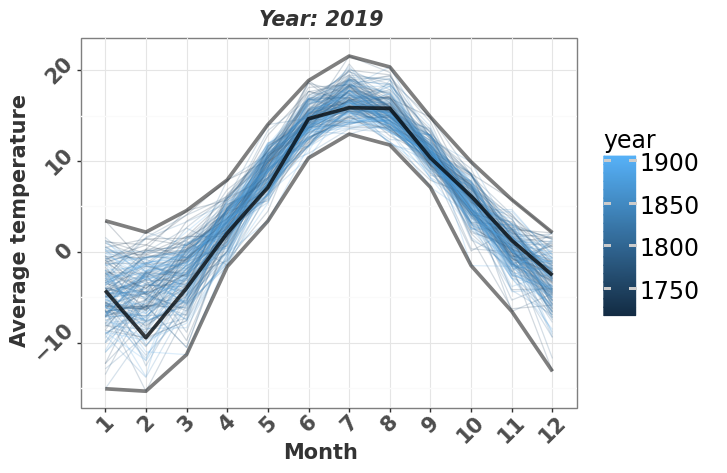

<ggplot: (8757986909020)>

In [55]:
"""
Cell used for easy testing of changes to the figures
"""

min_temp = df['obs_corr'].min()
max_temp = df['obs_corr'].max()
(ggplot(df.loc[df['year']==1900])+
      # all years passed
        geom_line(data = df.loc[df['year']<=1900],
                  mapping=aes(x='month', y='obs_corr', group='year', color="year",),
                  alpha = 0.2, size = 0.5) +
         scale_color_gradient(low = "#132B43",
                                  high = "#56B1F7"
                                )+
        # the min temperature for each month
        geom_line(mapping=aes(x='month', y='c_min', group='year'), alpha = 0.5, size = 1.5) +
        
        # the max temperature for each month
        geom_line(mapping=aes(x='month', y='c_max', group='year'), alpha = 0.5, size = 1.5) +
        
        # the temperature for this year
        geom_line(mapping= aes(x='month', y='obs_corr', group='year'), 
                  alpha = 0.75, size = 1.5) +
        
        ylim(min_temp, max_temp) +
        labs(title="Year: 2019", x='Month', y='Average temperature') # customizing labels
)